In [1]:
import os
import pandas as pd
import numpy as np
from numpy.testing import assert_array_equal
import mdtraj as md
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, ref_pdb, plot_type, window, image_molecules=False, title=None):
    #rmsd_arrays = []
    labels = []
    ref = md.load_pdb(ref_pdb)
    ref_CYPA_atoms = ref.topology.select('protein and chainid 0 and name CA')
    ref_KRAS_atoms = ref.topology.select('protein and chainid 1 and name CA')

    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)[::window]
        if image_molecules:
            traj.image_molecules(inplace=True)
        CYPA_atoms = traj.topology.select('protein and chainid 0 and name CA')
        KRAS_atoms = traj.topology.select('protein and chainid 1 and name CA')
        #
        try:
            assert_array_equal(ref_CYPA_atoms, CYPA_atoms)
            assert_array_equal(ref_KRAS_atoms, KRAS_atoms)
        except AssertionError as e:
            print("Assertion failed for atom indices between trajactory and reference")
        #
        traj.superpose(ref, frame=0, atom_indices=ref_CYPA_atoms)
        #traj.save_xtc(f'{i}_processed.xtc')
        #
        result = traj.xyz[:, KRAS_atoms, :] - ref.xyz[0, ref_KRAS_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        #n_windows = len(ligand_rmsd) // window
        #avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        #avg_frames = np.arange(n_windows) * window
        #rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(ligand_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(title)
        elif plot_type == 'hist':
            sns.kdeplot(ligand_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return None

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


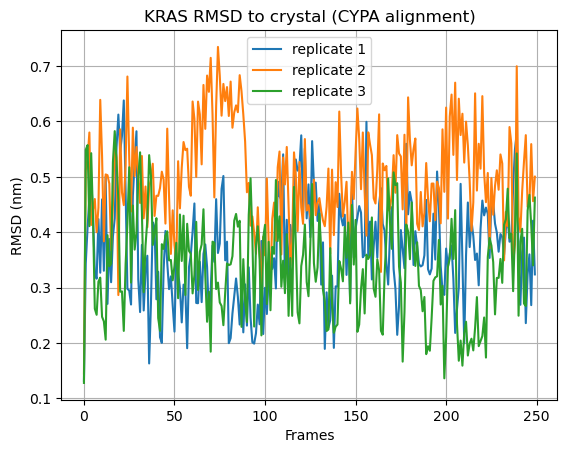

In [4]:
plot_rmsd_fluctuations_multiple(['long_test/crystal_0.dcd', 
                                 'long_test/crystal_1.dcd',
                                 'long_test/crystal_2.dcd',
                                 ],
                                'long_test/crystal_min.pdb', 
                                'crystal/crystal.pdb', 
                                'line', 100, image_molecules=True, title = 'KRAS RMSD to crystal (CYPA alignment)')

In [ ]:
def plot_rmsd_fluctuations_multiple_eliminate_sol(traj_files, top_file, ref_pdb, plot_type, window, image_molecules=False, title=None):

    labels = []
    ref = md.load_pdb(ref_pdb)
    ref_CYPA_atoms = ref.topology.select('protein and chainid 0 and name CA')
    ref_KRAS_atoms = ref.topology.select('protein and chainid 1 and name CA')

    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)[::window]
        traj = traj.remove_solvent(exclude=['MG'])

        if image_molecules:
            traj.image_molecules(inplace=True)
        CYPA_atoms = traj.topology.select('protein and chainid 0 and name CA')
        KRAS_atoms = traj.topology.select('protein and chainid 1 and name CA')
        #
        try:
            assert_array_equal(ref_CYPA_atoms, CYPA_atoms)
            assert_array_equal(ref_KRAS_atoms, KRAS_atoms)
        except AssertionError as e:
            print("Assertion failed for atom indices between trajactory and reference")
        #
        traj.superpose(ref, frame=0, atom_indices=ref_CYPA_atoms)
        traj.save_xtc(f'{i}_processed_nowater.xtc')
        #
        result = traj.xyz[:, KRAS_atoms, :] - ref.xyz[0, ref_KRAS_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        
        labels.append(f'replica {i+1}')
        if plot_type == 'line':
            plt.plot(ligand_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(title)
        elif plot_type == 'hist':
            sns.kdeplot(ligand_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title(title)

    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return None

In [ ]:
plot_rmsd_fluctuations_multiple_eliminate_sol(['long_test/cofold_0.dcd', 
                                                'long_test/cofold_1.dcd',
                                                'long_test/cofold_2.dcd',
                                                ],
                                                'long_test/cofold_min.pdb', 
                                                'cofold/cofold.pdb',
                                                'line', 100, image_molecules=True, title = 'KRAS RMSD to cofold (CYPA alignment)')

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


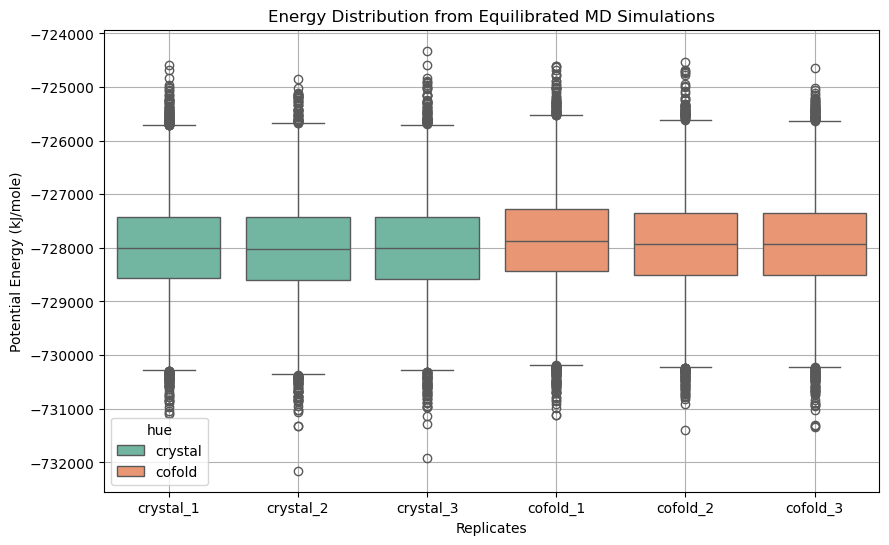

In [3]:
def plot_potential_energy(md_platform, state_file_list, plot_type, final_frames_to_use, window, title, labels=None, hues=None):
    energy_arrays = []
    plot_labels = []
    plot_hues = []
    
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')

            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Potential Energy (kJ/mole)']
        energy = df['Potential Energy (kJ/mole)'][-final_frames_to_use:].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        
        # Use custom label if provided, otherwise use default
        if labels is not None:
            plot_labels.append(labels[i])
        else:
            plot_labels.append(f'replicate {i+1}')
        
        # Use custom hue if provided, otherwise use default
        if hues is not None:
            plot_hues.append(hues[i])
        else:
            plot_hues.append(f'replicate {i+1}')

        if plot_type == 'line':
            plt.plot(avg_frames, avg_energy, label=plot_labels[i])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
            print(f'{plot_labels[i]}: Mean = {np.mean(avg_energy):.2f}, Std = {np.std(avg_energy):.2f}')
        elif plot_type == 'hist':
            sns.kdeplot(avg_energy, label=plot_labels[i])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title(title)
            print(f'{plot_labels[i]}: Mean = {np.mean(avg_energy):.2f}, Std = {np.std(avg_energy):.2f}')
        elif plot_type == 'box':
            energy_arrays.append(avg_energy)

    if plot_type == 'box':
        # Create a DataFrame for better control over box plot styling
        data_for_plot = []
        for label, hue, energy_array in zip(plot_labels, plot_hues, energy_arrays):
            for energy_value in energy_array:
                data_for_plot.append({'label': label, 'hue': hue, 'energy': energy_value})
        
        df_plot = pd.DataFrame(data_for_plot)
        
        # Create box plot with hue grouping
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_plot, x='label', y='energy', hue='hue', palette='Set2')
        plt.xlabel('Replicates')
        plt.ylabel('Potential Energy (kJ/mole)')
        plt.title(title)
        plt.grid(True, zorder=0)
        plt.show()
        plt.close()
    else:    
        plt.grid(True)
        plt.legend()
        plt.show()
        plt.close()


plot_potential_energy('openmm', ['long_test/crystal_0.csv', 
                                 'long_test/crystal_1.csv', 
                                 'long_test/crystal_2.csv',
                                 'long_test/cofold_0.csv',
                                 'long_test/cofold_1.csv',
                                 'long_test/cofold_2.csv',], 
                     'box', 20000, 1, 'Energy Distribution from Equilibrated MD Simulations',
                     labels=['crystal_1', 'crystal_2', 'crystal_3', 'cofold_1', 'cofold_2', 'cofold_3'],
                     hues=['crystal', 'crystal', 'crystal', 'cofold', 'cofold', 'cofold'])